<a href="https://colab.research.google.com/github/WJM999/wjm999.github.io/blob/main/%EA%B8%B0%EB%A7%90%EC%8B%9C%ED%97%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.

In [104]:
from google.colab import files
file_uploaded = files.upload()

Saving lenet_mnist_model.pth to lenet_mnist_model.pth


In [105]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# NOTE: 아래는 MNIST 데이터셋을 내려받을 때 "User-agent" 관련한 제한을 푸는 코드입니다.
#       더 자세한 내용은 https://github.com/pytorch/vision/issues/3497 을 참고해주세요.
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [106]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "data/lenet_mnist_model.pth"
use_cuda=True

epsilons은 실행에 사용할 엡실론의 리스트입니다.

pretrained_model은 pytorch/examples/mnist
를 통해 미리 학습된 MNIST 모델의 경로

use_cuda - CUDA 를 사용할지 말지 정하는 이진 플래그.

In [107]:
# LeNet 모델 정의
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST 테스트 데이터셋과 데이터로더 선언
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

# 어떤 디바이스를 사용할지 정의
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# 모델 초기화하기
model = Net().to(device)

# 미리 학습된 모델 읽어오기
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'),strict=False)

# 모델을 평가 모드로 설정하기. 드롭아웃 레이어들을 위해 사용됨
model.eval()



CUDA Available:  False


FileNotFoundError: ignored

위 코드에서는 모델과 데이터 로더를 정의한 다음, 모델을 초기화하고 미리 학습된 가중치를 읽어오는 것입니다.

In [90]:
# FGSM 공격 코드
def fgsm_attack(image, epsilon, data_grad):
    # data_grad 의 요소별 부호 값을 얻어옵니다
    sign_data_grad = data_grad.sign()
    # 입력 이미지의 각 픽셀에 sign_data_grad 를 적용해 작은 변화가 적용된 이미지를 생성합니다
    perturbed_image = image + epsilon*sign_data_grad
    # 값 범위를 [0,1]로 유지하기 위해 자르기(clipping)를 추가합니다
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # 작은 변화가 적용된 이미지를 리턴합니다
    return perturbed_image

fgsm_attack 함수는 입력 파라미터로 3가지를 가집니다. 첫 번째는 원본 이미지 ( xx ), 두 번째는 엡실론 으로 픽셀 단위의 작은 변화를 주는 값입니다 ( \epsilonϵ ). 마지막은 data_grad 로 입력 영상 ( \nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)∇ 
xJ(θ,x,y) ) 에 대한 변화도 손실 값입니다.

In [91]:
def test( model, device, test_loader, epsilon ):

    # 정확도 카운터
    correct = 0
    adv_examples = []

    # 테스트 셋의 모든 예제에 대해 루프를 돕니다
    for data, target in test_loader:

        # 디바이스(CPU or GPU) 에 데이터와 라벨 값을 보냅니다
        data, target = data.to(device), target.to(device)

        # 텐서의 속성 중 requires_grad 를 설정합니다. 공격에서 중요한 부분입니다
        data.requires_grad = True

        # 데이터를 모델에 통과시킵니다
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # 로그 확률의 최대값을 가지는 인덱스를 얻습니다

        # 만약 초기 예측이 틀리면, 공격하지 않도록 하고 계속 진행합니다
        if init_pred.item() != target.item():
            continue

        # 손실을 계산합니다
        loss = F.nll_loss(output, target)

        # 모델의 변화도들을 전부 0으로 설정합니다
        model.zero_grad()

        # 후방 전달을 통해 모델의 변화도를 계산합니다
        loss.backward()

        # 변화도 값을 모읍니다
        data_grad = data.grad.data

        # FGSM 공격을 호출합니다
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # 작은 변화가 적용된 이미지에 대해 재분류합니다
        output = model(perturbed_data)

        # 올바른지 확인합니다
        final_pred = output.max(1, keepdim=True)[1] # 로그 확률의 최대값을 가지는 인덱스를 얻습니다
        if final_pred.item() == target.item():
            correct += 1
            # 0 엡실론 예제에 대해서 저장합니다
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # 추후 시각화를 위하 다른 예제들을 저장합니다
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # 해당 엡실론에서의 최종 정확도를 계산합니다
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # 정확도와 적대적 예제를 리턴합니다
    return final_acc, adv_examples

위 테스트 함수는 테스트 기능을 호출할 때마다 MNIST 테스트 셋에서 전체 테스트 단계를 수행하고 최종 정확도를 보고합니다. 
 테스트 셋의 각각의 샘플에서 테스트 함수는 입력 데이터에 대한 손실 변화도( data\_graddata_grad )를 계산하고, FGSM 공격 (perturbed\_dataperturbed_data) 을 받은 작은 변화가 적용된 이미지를 만들고 나서 작은 변화가 적용된 이미지가 적대적인지 확인을 합니다. 

In [92]:
accuracies = []
examples = []

# 각 엡실론에 대해 테스트 함수를 실행합니다
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 982 / 10000 = 0.0982
Epsilon: 0.05	Test Accuracy = 936 / 10000 = 0.0936
Epsilon: 0.1	Test Accuracy = 846 / 10000 = 0.0846
Epsilon: 0.15	Test Accuracy = 744 / 10000 = 0.0744
Epsilon: 0.2	Test Accuracy = 664 / 10000 = 0.0664
Epsilon: 0.25	Test Accuracy = 635 / 10000 = 0.0635
Epsilon: 0.3	Test Accuracy = 638 / 10000 = 0.0638


위 코드는 공격을 실행하는 부분으로 전체 테스트 스텝을 각 엡실론 값에 실행합니다. 각 엡실론마다 최종 정확도와 성공적인 일부 적대 사례를 저장하여 다음 섹션에 표시합니다.

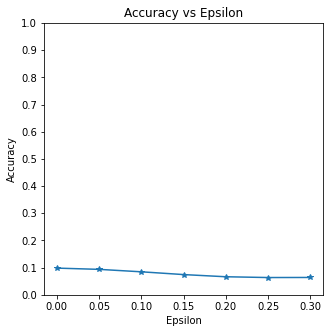

In [93]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

첫 번째 결과는 정확도 vs 엡실론 을 도식화 한 것 입니다. 앞에서 언급했듯이, 엡실론이 증가함에 따라 우리는 테스트 정확도가 감소할 것으로 예상합니다. 이는 학습을 더 진행해 갈수록 엡실론이 클수록 손실을 극대화 할 방향으로 진행되기 때문입니다. 

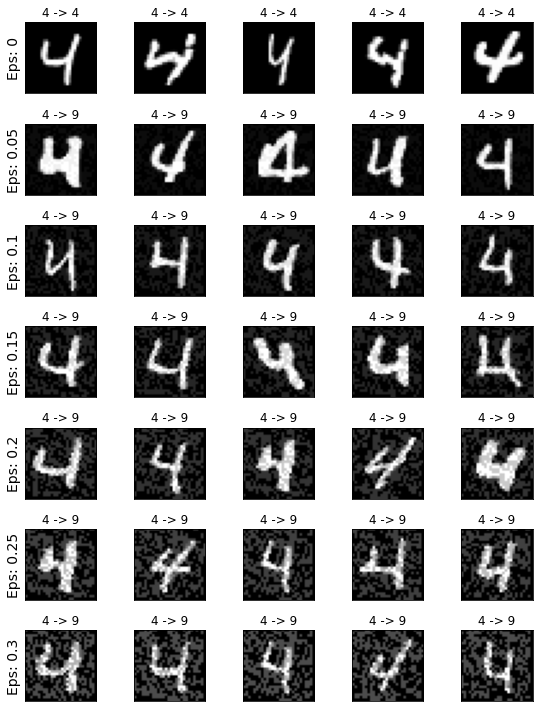

In [95]:
# 각 엡실론에서 적대적 샘플의 몇 가지 예를 도식화합니다
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

위 이미지의 첫번째로 열은 ϵ=0 인 예제들로 작은 변화가 없는 원본의 “깨끗한” 이미지들을 나타냅니다. 각 이미지의 위의 글자는 “원래 분류 결과 -> 적대적 분류 결과”를 나타냅니다.ϵ=0.15 에서 작은 변화가 눈에 띄기 시작하고 ϵ=0.3 에서는 확실해 보입니다.